# Tutorial 1 - Decision Tree - Regression

We will predict the price (`price` column) of an AirBNB listing in Boston given a number of features about the listing.

**Therefore, our unit of analysis is an AIRBNB LISTING**

# Setup

In [1]:
# Common imports
import numpy as np
import pandas as pd

np.random.seed(42)


# Get the data

In [2]:
#We will predict the "price" value in the data set:

airbnb = pd.read_csv("airbnb.csv")
airbnb.head()

,host_is_superhost,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,guests_included,price_per_extra_person,minimum_nights,number_of_reviews,number_days_btw_first_last_review,review_scores_rating,cancellation_policy,price,price_gte_150,price_category
0,0,0,Roslindale,42.282619,-71.133068,House,Entire home/apt,4,1.5,2.0,...,1,0,2,0,0,NaN,moderate,250,1,gte_226
1,0,1,Roslindale,42.286241,-71.134374,Apartment,Private room,2,1.0,1.0,...,0,0,2,36,804,94.0,moderate,65,0,lte_$75
2,1,1,Roslindale,42.292438,-71.135765,Apartment,Private room,2,1.0,1.0,...,1,20,3,41,2574,98.0,moderate,65,0,lte_$75
3,0,0,Roslindale,42.281106,-71.121021,House,Private room,4,1.0,1.0,...,2,25,1,1,0,100.0,moderate,75,0,lte_$75
4,1,1,Roslindale,42.284512,-71.136258,House,Private room,2,1.5,1.0,...,1,0,2,29,380,99.0,flexible,79,0,btw_$75-$150


# Split the data into train and test

In [3]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(airbnb, test_size=0.3)

### Be careful: we haven't seperated the target column yet

## Check the missing values

In [4]:
train_set.isna().sum()

host_is_superhost                      0
host_identity_verified                 0
neighbourhood_cleansed                 0
latitude                               0
longitude                              0
property_type                          2
room_type                              0
accommodates                           0
bathrooms                             10
bedrooms                               8
beds                                   6
bed_type                               0
Number of amenities                    0
guests_included                        0
price_per_extra_person                 0
minimum_nights                         0
number_of_reviews                      0
number_days_btw_first_last_review      0
review_scores_rating                 556
cancellation_policy                    0
price                                  0
price_gte_150                          0
price_category                         0
dtype: int64

In [5]:
test_set.isna().sum()

host_is_superhost                      0
host_identity_verified                 0
neighbourhood_cleansed                 0
latitude                               0
longitude                              0
property_type                          1
room_type                              0
accommodates                           0
bathrooms                              4
bedrooms                               2
beds                                   3
bed_type                               0
Number of amenities                    0
guests_included                        0
price_per_extra_person                 0
minimum_nights                         0
number_of_reviews                      0
number_days_btw_first_last_review      0
review_scores_rating                 244
cancellation_policy                    0
price                                  0
price_gte_150                          0
price_category                         0
dtype: int64

# Data Prep

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import FunctionTransformer

## Drop the variables we can't use in this tutorial

In [7]:
# We can't use the following columns in this tutorial, because they are for classification tasks

train = train_set.drop(['price_gte_150', 'price_category'], axis=1)
test = test_set.drop(['price_gte_150', 'price_category'], axis=1)

## Separate the target variable (we don't want to transform it)

In [8]:
train_y = train[['price']]
test_y = test[['price']]

train_inputs = train.drop(['price'], axis=1)
test_inputs = test.drop(['price'], axis=1)

## Feature Engineering: Let's derive a new column

#### Formula: `reviews per day` = `number of reviews` / `number_days_btw_first_last_review`

In [9]:
def new_col(df):
    
    #Create a copy so that we don't overwrite the existing dataframe
    df1 = df.copy()

    # Use the formula, though fill in 0s when the value is 0/0 (because 0/0 generates "nan" values)
    df1['reviews_per_day'] = (df1['number_of_reviews']/df1['number_days_btw_first_last_review']).fillna(0)

    # Replace the infinity values with 1 (because a value divided by 0 generates infinity)
    df1['reviews_per_day'].replace(np.inf, 1, inplace=True)

    return df1[['reviews_per_day']]
    # You can use this to check whether the calculation is made correctly:
    #return df1
    

In [10]:
#Let's test the new function:

# Send the train set to the function we created
new_col(train_set)

,reviews_per_day
1965,0.078689
1450,0.197468
2503,1.000000
944,0.000000
199,0.013405
...,...
1130,0.133607
1294,1.000000
860,0.136364
3507,0.000000


##  Identify the numerical and categorical columns

In [11]:
train_inputs.dtypes

host_is_superhost                      int64
host_identity_verified                 int64
neighbourhood_cleansed                object
latitude                             float64
longitude                            float64
property_type                         object
room_type                             object
accommodates                           int64
bathrooms                            float64
bedrooms                             float64
beds                                 float64
bed_type                              object
Number of amenities                    int64
guests_included                        int64
price_per_extra_person                 int64
minimum_nights                         int64
number_of_reviews                      int64
number_days_btw_first_last_review      int64
review_scores_rating                 float64
cancellation_policy                   object
dtype: object

**At this stage, you can manually identify numeric, binary, and categorical columns as follows:**

`numeric_columns = ['latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'Number of amenities', 'guests_included', 'price_per_extra_person', 'minimum_nights', 'number_of_reviews', 'number_days_btw_first_last_review', 'review_scores_rating']`
 
 `binary_columns = ['host_is_superhost', 'host_identity_verified']`
 
 `categorical_columns = ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type', 'cancellation_policy']`
 
<br>
 
**If you do not want to manually type these, you can do the below tricks:**

In [12]:
# Identify the numerical columns
numeric_columns = train_inputs.select_dtypes('number').columns.tolist()

# Identify the categorical columns
categorical_columns = train_inputs.select_dtypes('object').columns.tolist()

In [13]:
# Identify the binary columns so we can pass them through without transforming
binary_columns = ['host_is_superhost', 'host_identity_verified']

In [14]:
# Be careful: numerical columns already includes the binary columns,
# So, we need to remove the binary columns from numerical columns.

for col in binary_columns:
    numeric_columns.remove(col)

In [15]:
binary_columns

['host_is_superhost', 'host_identity_verified']

In [16]:
numeric_columns

['latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'Number of amenities',
 'guests_included',
 'price_per_extra_person',
 'minimum_nights',
 'number_of_reviews',
 'number_days_btw_first_last_review',
 'review_scores_rating']

In [17]:
categorical_columns

['neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bed_type',
 'cancellation_policy']

In [18]:
feat_eng_columns = ['number_of_reviews', 'number_days_btw_first_last_review']

# Pipeline

In [19]:
numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [20]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [21]:
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

In [22]:
my_new_column = Pipeline(steps=[('my_new_column', FunctionTransformer(new_col)),
                               ('scaler', StandardScaler())])

In [23]:
preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('binary', binary_transformer, binary_columns),
        ('trans', my_new_column, feat_eng_columns)],
        remainder='passthrough')

# passtrough is an optional step as we transform all the columns. If there were any 
# remaining column, if we don't include passthrough the remaining columns would 
# be dropped.

# Transform: fit_transform() for TRAIN

In [24]:
#Fit and transform the train data
train_x = preprocessor.fit_transform(train_inputs)

train_x

array([[ 0.82254842,  0.69215829,  0.54753414, ...,  1.        ,
         1.        , -0.34475133],
       [ 0.55146572,  0.15729058,  0.54753414, ...,  0.        ,
         1.        ,  0.03408048],
       [ 0.07311286, -1.97951247, -0.59100739, ...,  0.        ,
         0.        ,  2.59364398],
       ...,
       [-0.61093878, -0.07631528,  3.96315871, ...,  0.        ,
         1.        , -0.16080455],
       [ 1.17819153, -0.94575177, -1.16027815, ...,  0.        ,
         0.        , -0.59571748],
       [-0.33618088,  1.03587419, -0.59100739, ...,  0.        ,
         1.        , -0.59571748]])

In [25]:
train_x.shape

(2488, 67)

# Tranform: transform() for TEST

In [26]:
# Transform the test data
test_x = preprocessor.transform(test_inputs) # be sure you don't call fit again!

test_x

array([[-1.21269719, -1.20324989,  0.54753414, ...,  0.        ,
         1.        ,  0.77115172],
       [-2.86419979, -2.67831359, -0.59100739, ...,  0.        ,
         0.        , -0.59571748],
       [-0.11443035,  1.26295963, -0.59100739, ...,  0.        ,
         1.        , -0.50662917],
       ...,
       [ 0.47803436, -1.63486781, -0.59100739, ...,  1.        ,
         1.        , -0.24904775],
       [ 0.59928397,  0.34795157,  2.82461719, ...,  0.        ,
         0.        , -0.45008453],
       [ 0.19953968,  0.22845713, -0.59100739, ...,  0.        ,
         1.        , -0.59571748]])

In [27]:
test_x.shape

(1067, 67)

# Calculate the baseline

In [28]:
from sklearn.dummy import DummyRegressor

dummy_regr = DummyRegressor(strategy="mean")

dummy_regr.fit(train_x, train_y)

DummyRegressor()

In [29]:
from sklearn.metrics import mean_squared_error

In [30]:
#Baseline Train RMSE
dummy_train_pred = dummy_regr.predict(train_x)

baseline_train_mse = mean_squared_error(train_y, dummy_train_pred)

baseline_train_rmse = np.sqrt(baseline_train_mse)

print('Baseline Train RMSE: {}' .format(baseline_train_rmse))

Baseline Train RMSE: 103.84299127618122


In [31]:
#Baseline Test RMSE
dummy_test_pred = dummy_regr.predict(test_x)

baseline_test_mse = mean_squared_error (test_y, dummy_test_pred)

baseline_test_rmse = np.sqrt(baseline_test_mse)

print('Baseline Test RMSE: {}' .format(baseline_test_rmse))

Baseline Test RMSE: 102.31125032666752


# Decision Tree

Do NOT train a DecisionTreeRegressor() without any parameters. It OVERFITS. 

In [32]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=10) 

tree_reg.fit(train_x, train_y)

DecisionTreeRegressor(max_depth=10)

In [33]:
#Train RMSE
train_pred = tree_reg.predict(train_x)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

Train RMSE: 43.12633335480884


In [34]:
#Test RMSE
test_pred = tree_reg.predict(test_x)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))

Test RMSE: 75.82030425514189


## More regularization

In [35]:
#Let's restrict the minimum samples per leaf node

tree_reg2 = DecisionTreeRegressor(min_samples_leaf = 10, max_depth=10) 

tree_reg2.fit(train_x, train_y)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=10)

In [36]:
#Train RMSE
train_pred = tree_reg2.predict(train_x)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

Train RMSE: 55.10550818442154


In [37]:
#Test RMSE
test_pred = tree_reg2.predict(test_x)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))

Test RMSE: 69.83395596303043


## Feature Importance

In [38]:
# There are 62 columns, so there are 62 values for each column's importance
# Values are rounded to three decimals

np.round(tree_reg2.feature_importances_,3)

array([0.079, 0.051, 0.021, 0.169, 0.044, 0.008, 0.012, 0.001, 0.001,
       0.008, 0.006, 0.011, 0.003, 0.   , 0.017, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.011, 0.014, 0.   , 0.   , 0.005, 0.   ,
       0.   , 0.   , 0.001, 0.001, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.009, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.489, 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.001, 0.   , 0.014,
       0.003, 0.   , 0.001, 0.02 ])

In [39]:
# The importance of the last column (i.e., the one we derived)

np.round(tree_reg2.feature_importances_,3)[-1]

0.02

## Avoid Overfitting

In [40]:
train_error = []
test_error = []

for x in range(1,31):
    tree_reg3 = DecisionTreeRegressor(max_depth=x)
    tree_reg3.fit(train_x, train_y)
    reg_train_predictions = tree_reg3.predict(train_x)
    reg_test_predictions = tree_reg3.predict(test_x)
    train_rmse = round(np.sqrt(mean_squared_error (train_y, reg_train_predictions)),4)
    test_rmse = round(np.sqrt(mean_squared_error (test_y, reg_test_predictions)),4)
    print('# Max depth = {}'.format(x) + "     " +'Train RMSE = {}'.format(train_rmse) + "   "
         'Test RMSE = {}'.format(test_rmse))
    
    train_error.append(train_rmse)
    test_error.append(test_rmse)


# Max depth = 1     Train RMSE = 83.6407   Test RMSE = 81.0052
# Max depth = 2     Train RMSE = 76.1585   Test RMSE = 73.5922
# Max depth = 3     Train RMSE = 72.4286   Test RMSE = 72.0469
# Max depth = 4     Train RMSE = 68.3877   Test RMSE = 69.0542
# Max depth = 5     Train RMSE = 64.9798   Test RMSE = 68.1194
# Max depth = 6     Train RMSE = 61.2586   Test RMSE = 67.8091
# Max depth = 7     Train RMSE = 56.8107   Test RMSE = 67.8576
# Max depth = 8     Train RMSE = 52.1236   Test RMSE = 70.777
# Max depth = 9     Train RMSE = 47.4807   Test RMSE = 75.6694
# Max depth = 10     Train RMSE = 43.1263   Test RMSE = 77.7179
# Max depth = 11     Train RMSE = 39.007   Test RMSE = 79.0237
# Max depth = 12     Train RMSE = 34.8543   Test RMSE = 77.4281
# Max depth = 13     Train RMSE = 30.916   Test RMSE = 76.9862
# Max depth = 14     Train RMSE = 27.6714   Test RMSE = 79.3506
# Max depth = 15     Train RMSE = 23.853   Test RMSE = 79.8255
# Max depth = 16     Train RMSE = 19.7633   Test RMSE

In [41]:
from matplotlib import pyplot as plt

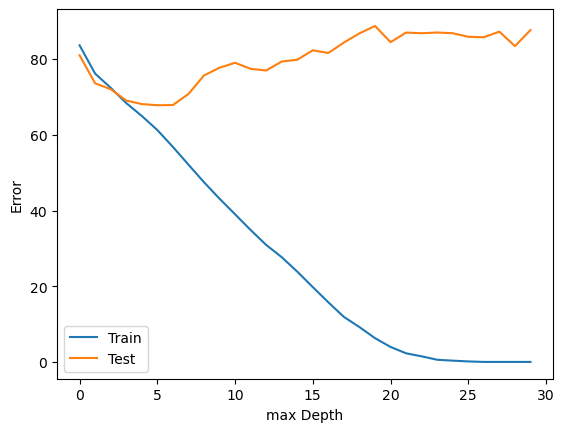

In [42]:
plt.plot(train_error, label='Train')
plt.plot(test_error, label='Test')
plt.xlabel("max Depth")
plt.ylabel("Error")
plt.legend()

# Randomized Grid Search

In [43]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = [
    {'min_samples_leaf': np.arange(1, 30), 
     'max_depth': np.arange(1,30)}
  ]

tree_reg = DecisionTreeRegressor()

grid_search = RandomizedSearchCV(tree_reg, param_grid, cv=5, n_iter=10,
                           scoring='neg_mean_squared_error', verbose=1,
                           return_train_score=True)

grid_search.fit(train_x, train_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(),
                   param_distributions=[{'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                                         'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])}],
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [44]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

69.50495655512186 {'min_samples_leaf': 15, 'max_depth': 29}
69.60938015434697 {'min_samples_leaf': 23, 'max_depth': 17}
75.21666790383155 {'min_samples_leaf': 2, 'max_depth': 9}
80.34108626579317 {'min_samples_leaf': 1, 'max_depth': 12}
68.67238990914527 {'min_samples_leaf': 27, 'max_depth': 7}
70.84334339656552 {'min_samples_leaf': 7, 'max_depth': 6}
69.73916112149294 {'min_samples_leaf': 29, 'max_depth': 20}
72.9082818084493 {'min_samples_leaf': 8, 'max_depth': 17}
76.52822260653117 {'min_samples_leaf': 8, 'max_depth': 2}
69.40139583658909 {'min_samples_leaf': 21, 'max_depth': 8}


In [45]:
grid_search.best_params_

{'min_samples_leaf': 27, 'max_depth': 7}

In [46]:
grid_search.best_estimator_

DecisionTreeRegressor(max_depth=7, min_samples_leaf=27)

In [47]:
#Train RMSE
train_pred = grid_search.best_estimator_.predict(train_x)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

Train RMSE: 63.276570509152236


In [48]:
#Test RMSE
test_pred = grid_search.best_estimator_.predict(test_x)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))

Test RMSE: 68.99662271297818
